In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
df=pd.read_csv("NewTrain.csv")
dff=pd.read_csv("questions.csv")

In [ ]:
merged_df = pd.merge(df, dff, how='left', left_on='content_id', right_on='question_id')
merged_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags
0,5834979,47774654,125647633,6446,0,33.0,2.0,1.0,18000.0,True,6446.0,6446.0,2.0,5.0,91
1,95503815,763883008,2026139983,5892,0,523.0,1.0,0.0,27000.0,True,5892.0,5892.0,3.0,5.0,66
2,54181523,49949152546,1149023497,1369,0,623.0,3.0,0.0,16000.0,True,1369.0,1369.0,1.0,2.0,90 100 38 81
3,61371420,1794515750,1302436168,3441,0,188.0,0.0,1.0,30000.0,True,3441.0,3441.0,0.0,4.0,74 12 81
4,14542144,1240580366,313851832,5172,0,593.0,1.0,0.0,12000.0,True,5172.0,5172.0,2.0,5.0,181


In [ ]:
merged_df.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'question_id', 'bundle_id', 'correct_answer', 'part', 'tags'],
      dtype='object')

# **Preprocessing**

In [ ]:
# Convert `prior_question_had_explanation` to boolean
# Fill NaN values in 'prior_question_had_explanation' with False
merged_df['prior_question_had_explanation'] = merged_df['prior_question_had_explanation'].fillna(False)

In [ ]:
# Fill NaN values in `prior_question_elapsed_time` with the median value to avoid extreme values
merged_df['prior_question_elapsed_time'] = merged_df['prior_question_elapsed_time'].fillna(merged_df['prior_question_elapsed_time'].median())

In [ ]:
# Ensure 'answered_correctly' and 'user_answer' are numeric
merged_df['answered_correctly'] = pd.to_numeric(merged_df['answered_correctly'], errors='coerce').fillna(0).astype(int)
merged_df['user_answer'] = pd.to_numeric(merged_df['user_answer'], errors='coerce').fillna(0).astype(int)

In [ ]:
# Calculate the average_correctness rate for each content_id
average_correctness = merged_df.groupby('content_id')['answered_correctly'].mean().reset_index()
average_correctness.columns = ['content_id', 'average_correctness']

In [ ]:
# Calculate the average_elapsed_time rate for each content_id
average_elapsed_time = merged_df.groupby('content_id')['prior_question_elapsed_time'].mean().reset_index()
average_elapsed_time.columns = ['content_id', 'average_elapsed_time']

In [ ]:
# Add the two calculated rates columns to the dataset
merged_df = merged_df.merge(average_correctness, on='content_id', how='left')
merged_df = merged_df.merge(average_elapsed_time, on='content_id', how='left')

In [ ]:
##Fill NaN values in 'part' and 'tags' columns
merged_df['part'] = merged_df['part'].fillna(-1).astype(int)
merged_df['tags'] = merged_df['tags'].fillna('unknown')

In [ ]:
# Label encoding for categorical columns
label_encoder = LabelEncoder()
merged_df['tags'] = label_encoder.fit_transform(merged_df['tags'])

In [ ]:
# Drop columns that are not useful for the model
merged_df = merged_df.drop(columns=['row_id', 'question_id'])

In [ ]:
# Handle remaining NaN values if any
merged_df = merged_df.fillna({
    'average_correctness': merged_df['average_correctness'].mean(),
    'average_elapsed_time': merged_df['average_elapsed_time'].median()
})

In [ ]:
# Convert timestamp to a datetime object for potential time-based features
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], unit='ms')

In [ ]:
merged_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,average_correctness,average_elapsed_time
0,1970-01-01 13:16:14.654,125647633,6446,0,33.0,2,1,18000.0,True,6446.0,2.0,5,1366,0.857143,26000.000000
1,1970-01-09 20:11:23.008,2026139983,5892,0,523.0,1,0,27000.0,True,5892.0,3.0,5,1054,0.925926,31657.407407
2,1971-08-02 02:45:52.546,1149023497,1369,0,623.0,3,0,16000.0,True,1369.0,1.0,2,1350,0.595960,21205.383838
3,1970-01-21 18:28:35.750,1302436168,3441,0,188.0,0,1,30000.0,True,3441.0,0.0,4,1103,0.565217,26260.652174
4,1970-01-15 08:36:20.366,313851832,5172,0,593.0,1,0,12000.0,True,5172.0,2.0,5,846,0.379310,20120.689655


# **Feature Engineering**

In [ ]:
#Extract date and time features from the timestamp
merged_df['year'] = merged_df['timestamp'].dt.year
merged_df['month'] = merged_df['timestamp'].dt.month
merged_df['day'] = merged_df['timestamp'].dt.day
merged_df['hour'] = merged_df['timestamp'].dt.hour
merged_df['day_of_week'] = merged_df['timestamp'].dt.dayofweek

In [ ]:
#Calculate the number of questions answered by each user
user_question_count = merged_df.groupby('user_id')['content_id'].count().reset_index()
user_question_count.columns = ['user_id', 'user_question_count']
merged_df = merged_df.merge(user_question_count, on='user_id', how='left')

In [ ]:
#Calculate the cumulative correctness for each user
merged_df['cumulative_correctness'] = merged_df.groupby('user_id')['answered_correctly'].cumsum()

In [ ]:
#Calculate the average elapsed time per user
user_avg_elapsed_time = merged_df.groupby('user_id')['prior_question_elapsed_time'].mean().reset_index()
user_avg_elapsed_time.columns = ['user_id', 'user_avg_elapsed_time']
merged_df = merged_df.merge(user_avg_elapsed_time, on='user_id', how='left')

In [ ]:
#Calculate the user’s performance ratio (correct answers/total answers)
user_performance = merged_df.groupby('user_id')['answered_correctly'].mean().reset_index()
user_performance.columns = ['user_id', 'user_performance']
merged_df = merged_df.merge(user_performance, on='user_id', how='left')

In [ ]:
#Calculate the user’s performance ratio (correct answers/total answers)
user_performance = merged_df.groupby('user_id')['answered_correctly'].mean().reset_index()
user_performance.columns = ['user_id', 'user_performance']
merged_df = merged_df.merge(user_performance, on='user_id', how='left')

In [ ]:
# Calculate the average number of attempts per question
question_attempt_count = merged_df.groupby('content_id')['user_id'].count().reset_index()
question_attempt_count.columns = ['content_id', 'question_attempt_count']
merged_df = merged_df.merge(question_attempt_count, on='content_id', how='left')

In [ ]:
#Create a feature for the average time spent on a question
question_avg_time = merged_df.groupby('content_id')['prior_question_elapsed_time'].mean().reset_index()
question_avg_time.columns = ['content_id', 'question_avg_time']
merged_df = merged_df.merge(question_avg_time, on='content_id', how='left')

In [ ]:
#Create a binary feature indicating whether the user had an explanation in the prior question
merged_df['prior_question_had_explanation'] = merged_df['prior_question_had_explanation'].fillna(False).astype(int)
merged_df['had_explanation'] = merged_df['prior_question_had_explanation']


In [ ]:
merged_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,...,hour,day_of_week,user_question_count,cumulative_correctness,user_avg_elapsed_time,user_performance_x,user_performance_y,question_attempt_count,question_avg_time,had_explanation
0,1970-01-01 13:16:14.654,125647633,6446,0,33.0,2,1,18000.0,1,6446.0,...,13,3,1,1,18000.000000,1.000000,1.000000,21,26000.000000,1
1,1970-01-09 20:11:23.008,2026139983,5892,0,523.0,1,0,27000.0,1,5892.0,...,20,4,14,0,28380.857143,0.500000,0.500000,27,31657.407407,1
2,1971-08-02 02:45:52.546,1149023497,1369,0,623.0,3,0,16000.0,1,1369.0,...,2,0,3,0,16666.666667,0.666667,0.666667,99,21205.383838,1
3,1970-01-21 18:28:35.750,1302436168,3441,0,188.0,0,1,30000.0,1,3441.0,...,18,2,1,1,30000.000000,1.000000,1.000000,23,26260.652174,1
4,1970-01-15 08:36:20.366,313851832,5172,0,593.0,1,0,12000.0,1,5172.0,...,8,3,6,0,24750.000000,0.500000,0.500000,58,20120.689655,1


# **Modelling**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Define the target variable based on average_correctness
merged_df['difficulty'] = pd.cut(merged_df['average_correctness'], bins=[-np.inf, 0.5, 0.75, np.inf], labels=[2, 1, 0]).astype(int)

In [ ]:
#Define the features and the target variable
features = merged_df.drop(columns=['difficulty', 'timestamp', 'average_correctness', 'correct_answer', 'average_elapsed_time'])
target = merged_df['difficulty']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler


# Categorize 'average_correctness' into difficulty levels
conditions = [
    (merged_df['average_correctness'] <= 0.33),
    (merged_df['average_correctness'] > 0.33) & (merged_df['average_correctness'] <= 0.66),
    (merged_df['average_correctness'] > 0.66)
]
choices = ['Hard', 'Medium', 'Easy']
merged_df['difficulty_level'] = np.select(conditions, choices, default='Medium')

# Select numeric columns only and handle NaNs
numeric_columns = merged_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
X = merged_df[numeric_columns].drop('average_correctness', axis=1)  # Exclude the original continuous target
y = merged_df['difficulty_level']  # This is your new categorical target

# Fill NaN values
X.fillna(X.mean(), inplace=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Using Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import  cross_val_score
# Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)
y_pred_nb = nb_model.predict(X_test_scaled)


cv_scores = cross_val_score(nb_model, X_train_scaled, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

print("\n")
# Evaluate Naive Bayes Model

print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Cross-Validation Scores: [0.62273329 0.62399798 0.62317346 0.62325129 0.62371826]
Mean Accuracy: 0.6233748546307496


Naive Bayes Classification Report:
              precision    recall  f1-score   support

        Easy       0.72      0.89      0.79     33102
        Hard       0.39      0.98      0.56      5814
      Medium       0.57      0.20      0.29     25329

    accuracy                           0.62     64245
   macro avg       0.56      0.69      0.55     64245
weighted avg       0.63      0.62      0.58     64245



### Using Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import  cross_val_score

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

print("\n")
# Evaluate Random Forest Model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
# Calculate and print the test accuracy
test_accuracy = accuracy_score(y_test, y_pred_rf)
print("Test Accuracy:", test_accuracy)

# Compare CV mean accuracy with test accuracy
if cv_scores.mean() > test_accuracy:
    print("Potential overfitting detected: Cross-Validation accuracy is higher than Test accuracy.")
else:
    print("No overfitting detected: Cross-Validation and Test accuracies are similar.")

Cross-Validation Scores: [0.98385088 0.98451241 0.984337   0.98398677 0.9827026 ]
Mean Accuracy: 0.9838779322373898


Random Forest Classification Report:
              precision    recall  f1-score   support

        Easy       1.00      0.99      0.99     33102
        Hard       1.00      0.95      0.97      5814
      Medium       0.98      0.99      0.99     25329

    accuracy                           0.99     64245
   macro avg       0.99      0.98      0.98     64245
weighted avg       0.99      0.99      0.99     64245

Test Accuracy: 0.9886528134485174
No overfitting detected: Cross-Validation and Test accuracies are similar.


### Using SVMs
Commented as no output produced due to high processing time

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC

# # Taking a 2% random sample from the original dataset for training and testing
# sample_size = int(0.02 * len(X_train_scaled))
# X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_train_scaled, y_train, test_size=sample_size, random_state=42)

# # SVM Model
# svm_model = SVC(kernel='linear', random_state=42)
# svm_model.fit(X_train_small, y_train_small)
# y_pred_svm = svm_model.predict(X_test_scaled)

# # Cross-validation scores
# cv_scores_svm = cross_val_score(svm_model, X_train_small, y_train_small, cv=5)
# print("SVM Cross-Validation Scores:", cv_scores_svm)
# print("Mean Accuracy:", cv_scores_svm.mean())

# # Evaluate SVM Model
# print("\nSVM Classification Report:")
# print(classification_report(y_test_small, y_pred_svm))

# # Calculate and print the test accuracy for SVM
# test_accuracy_svm = accuracy_score(y_test_small, y_pred_svm)
# print("Test Accuracy for SVM:", test_accuracy_svm)

# # Compare CV mean accuracy with test accuracy for SVM
# if cv_scores_svm.mean() > test_accuracy_svm:
#     print("Potential overfitting detected: SVM Cross-Validation accuracy is higher than Test accuracy.")
# else:
#     print("No overfitting detected: SVM Cross-Validation and Test accuracies are similar.")


### Using Neural Networks

Epoch 1/20
3213/3213 [==============================] - 12s 3ms/step - loss: 0.4909 - accuracy: 0.7347 - val_loss: 0.4190 - val_accuracy: 0.7574
Epoch 2/20
3213/3213 [==============================] - 10s 3ms/step - loss: 0.4260 - accuracy: 0.7542 - val_loss: 0.4113 - val_accuracy: 0.7650
Epoch 3/20
3213/3213 [==============================] - 11s 3ms/step - loss: 0.4189 - accuracy: 0.7586 - val_loss: 0.4045 - val_accuracy: 0.7722
Epoch 4/20
3213/3213 [==============================] - 10s 3ms/step - loss: 0.4126 - accuracy: 0.7621 - val_loss: 0.3984 - val_accuracy: 0.7713
Epoch 5/20
3213/3213 [==============================] - 9s 3ms/step - loss: 0.4077 - accuracy: 0.7646 - val_loss: 0.3931 - val_accuracy: 0.7772
Epoch 6/20
3213/3213 [==============================] - 11s 3ms/step - loss: 0.4046 - accuracy: 0.7663 - val_loss: 0.3891 - val_accuracy: 0.7787
Epoch 7/20
3213/3213 [==============================] - 11s 3ms/step - loss: 0.4026 - accuracy: 0.7683 - val_loss: 0.3888 - val_acc

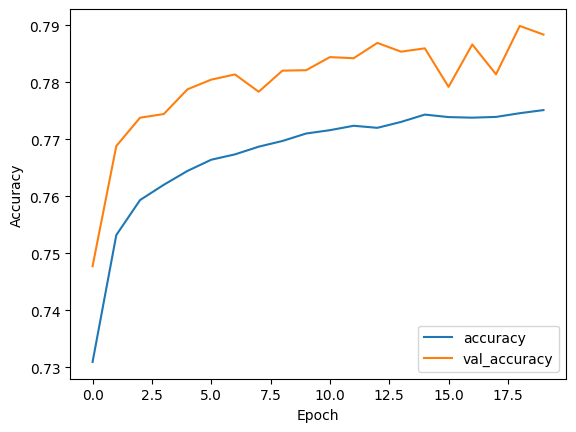

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure labels are one-hot encoded
y_train_categorical = to_categorical(y_train_encoded, num_classes=3)
y_test_categorical = to_categorical(y_test_encoded, num_classes=3)


num_folds = 5

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store accuracy for each fold
fold_accuracies = []

# Iterate over each fold
for train_index, val_index in kf.split(X_train_scaled):
    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train_categorical[train_index], y_train_categorical[val_index]

    # Create a new model instance
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # 3 output classes: Hard, Medium, Easy
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model on this fold
    history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=64, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model on the validation set for this fold
    _, accuracy = model.evaluate(X_val_fold, y_val_fold)
    print("Validation Accuracy for Fold:", accuracy)
    fold_accuracies.append(accuracy)

# Calculate and print the mean validation accuracy across all folds
mean_val_accuracy = np.mean(fold_accuracies)
print("Mean Validation Accuracy:", mean_val_accuracy)

# Now, train the model on the entire training data
model.fit(X_train_scaled, y_train_categorical, epochs=20, batch_size=64)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_categorical)
print("Test Accuracy for Neural Network:", test_accuracy)

# Plot training history for the last fold (as an example)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Using Decision Trees

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
# Instantiate the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=5)

# Train the model on the scaled features
clf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = clf.predict(X_test_scaled)

# Assess the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
# Generate classification report
class_report = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:")
print(class_report)


Accuracy: 0.9947233247723558
Cross-validation scores: [0.99069967 0.99196436 0.99138048 0.99254791 0.99058274]
Mean cross-validation score: 0.9914350319524446
Classification Report:
              precision    recall  f1-score   support

        Easy       1.00      1.00      1.00     33102
        Hard       0.98      0.99      0.99      5814
      Medium       0.99      0.99      0.99     25329

    accuracy                           0.99     64245
   macro avg       0.99      0.99      0.99     64245
weighted avg       0.99      0.99      0.99     64245



# **Evaluation**

Naive Bayes Accuracy: 0.6235037746128104
Precision: 0.6305393055373534
Recall: 0.6235037746128104
F1 score: 0.5756170304909063
Confusion Matrix:


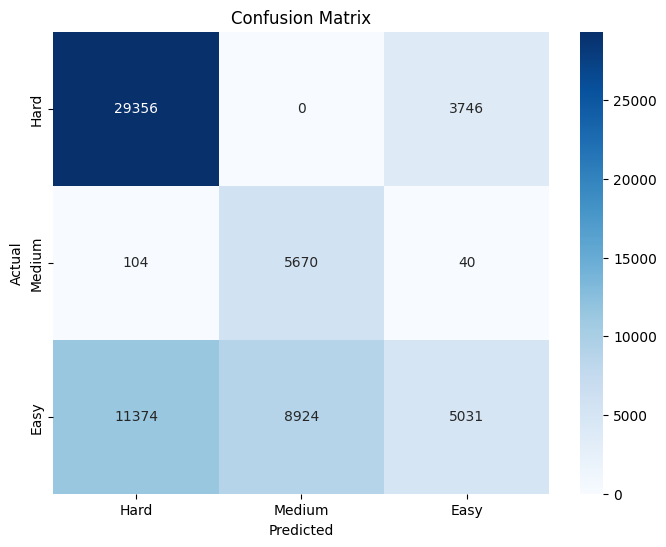

In [ ]:
from sklearn.metrics import precision_score,recall_score, f1_score
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average="weighted"))
print('Recall:', recall_score(y_test,y_pred_nb, average="weighted"))
print('F1 score:', f1_score(y_test, y_pred_nb, average="weighted"))

#confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_nb)
print("Confusion Matrix:")


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hard', 'Medium', 'Easy'], yticklabels=['Hard', 'Medium', 'Easy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Random Forest Accuracy: 0.9886528134485174
Precision: 0.9888020133003423
Recall: 0.9886528134485174
F1 score: 0.9886417310151775
Confusion Matrix:


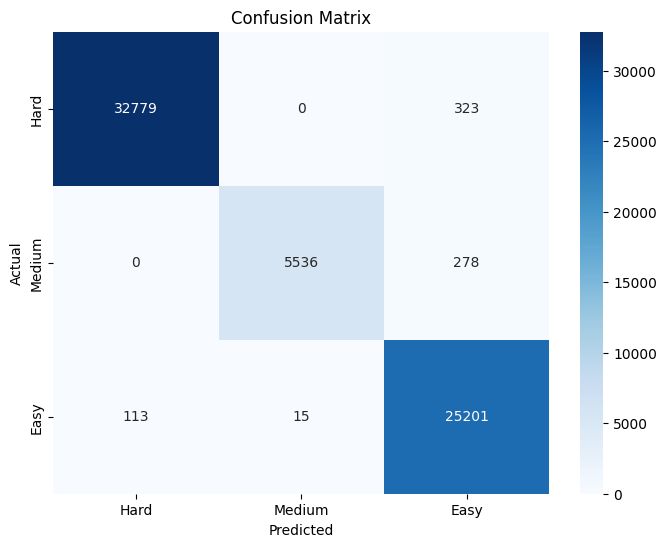

In [ ]:
from sklearn.metrics import precision_score,recall_score, f1_score
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average="weighted"))
print('Recall:', recall_score(y_test,y_pred_rf, average="weighted"))
print('F1 score:', f1_score(y_test, y_pred_rf, average="weighted"))

#confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hard', 'Medium', 'Easy'], yticklabels=['Hard', 'Medium', 'Easy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

2008/2008 [==============================] - 8s 4ms/step
Neural Network Accuracy: 0.78529068409993
Neural Network Precision: 0.8343643824901165
Neural Network Recall: 0.78529068409993
Neural Network F1 Score: 0.7830939373335419
Neural Network Confusion Matrix:


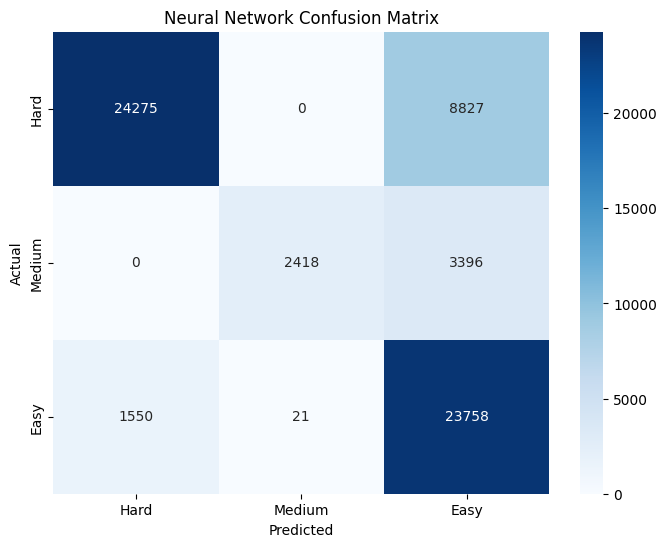

Classification Report for Neural Network:
              precision    recall  f1-score   support

        Easy       0.94      0.73      0.82     33102
        Hard       0.99      0.42      0.59      5814
      Medium       0.66      0.94      0.78     25329

    accuracy                           0.79     64245
   macro avg       0.86      0.70      0.73     64245
weighted avg       0.83      0.79      0.78     64245



In [ ]:

# Accuracy
y_pred_nn = model.predict(X_test_scaled)
y_pred_nn = np.argmax(y_pred_nn, axis=1)
nn_accuracy = accuracy_score(np.argmax(y_test_categorical, axis=1), y_pred_nn)
print("Neural Network Accuracy:", nn_accuracy)

# Precision
nn_precision = precision_score(np.argmax(y_test_categorical, axis=1), y_pred_nn, average="weighted")
print("Neural Network Precision:", nn_precision)

# Recall
nn_recall = recall_score(np.argmax(y_test_categorical, axis=1), y_pred_nn, average="weighted")
print("Neural Network Recall:", nn_recall)

# F1 Score
nn_f1_score = f1_score(np.argmax(y_test_categorical, axis=1), y_pred_nn, average="weighted")
print("Neural Network F1 Score:", nn_f1_score)

# Confusion Matrix
cm_nn = confusion_matrix(np.argmax(y_test_categorical, axis=1), y_pred_nn)
print("Neural Network Confusion Matrix:")


# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', xticklabels=['Hard', 'Medium', 'Easy'], yticklabels=['Hard', 'Medium', 'Easy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Neural Network Confusion Matrix')
plt.show()

class_report_nn = classification_report(np.argmax(y_test_categorical, axis=1), y_pred_nn, target_names=label_encoder.classes_)
print("Classification Report for Neural Network:")
print(class_report_nn)




Decision Tree Accuracy: 0.9947233247723558
Precision: 0.994728637721989
Recall: 0.9947233247723558
F1 score: 0.9947255871323848
Confusion Matrix:

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82     33102
           1       0.99      0.42      0.59      5814
           2       0.66      0.94      0.78     25329

    accuracy                           0.79     64245
   macro avg       0.86      0.70      0.73     64245
weighted avg       0.83      0.79      0.78     64245



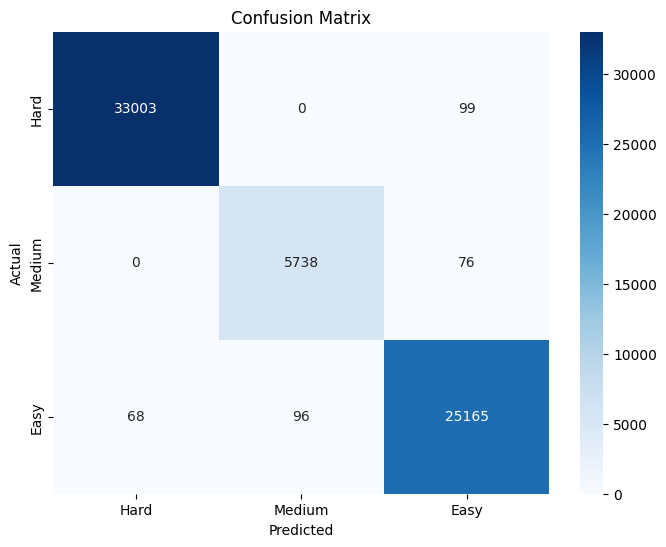

In [ ]:
# Calculate accuracy
accuracy_dt = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy:", accuracy_dt)

# Calculate precision
precision_dt = precision_score(y_test, y_pred, average="weighted")
print("Precision:", precision_dt)

# Calculate recall
recall_dt = recall_score(y_test, y_pred, average="weighted")
print('Recall:', recall_dt)

# Calculate F1 score
f1_dt = f1_score(y_test, y_pred, average="weighted")
print('F1 score:', f1_dt)

# Confusion matrix
cm_dt = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
# Classification report
print("\nDecision Tree Classification Report:")
print(classification_report(np.argmax(y_test_categorical, axis=1), y_pred_nn))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=choices, yticklabels=choices)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Interpretation**

Use model interpretation techniques like feature importance to understand which features most influence the prediction of question difficulty.

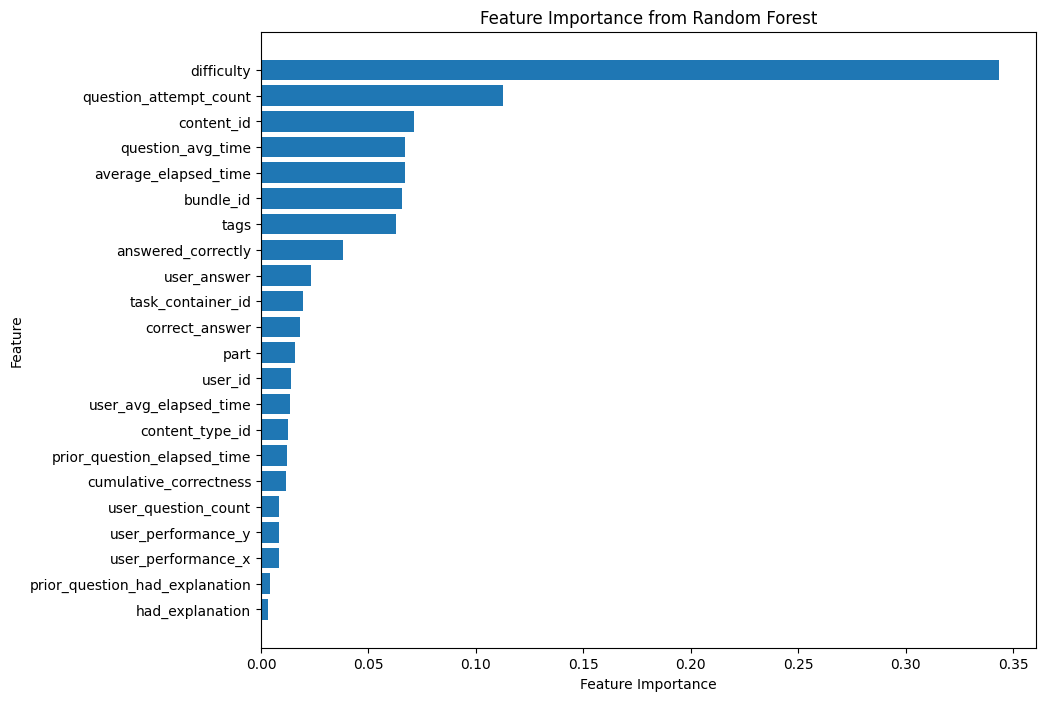

In [ ]:
# Assuming rf_model is your trained RandomForestClassifier
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()
